In [1]:
#torchvision을 사용해 데이터 불러오기
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor()])

#train data와 test data를 다운로드
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5     # unnormalize 다시 [0, 1]로 바꿈
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
#
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #convolution layer, pooling layer, fully connected layer 정의
        self.conv1 = nn.Conv2d(1, 6, 5) # input channels, output channels, kernel(fliter) size, 1 * 28 * 28 ->  6 * 24 * 24
        #(28 - 5) + 1 이므로 24가 됨.
        self.pool = nn.MaxPool2d(2)  # kernel size, stride = 1, padding = 0 (default) stride를 2로하면 4씩 작아지니까
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 * 12 * 12 -> 16 * 8 * 8
        self.fc1 = nn.Linear(16 * 4 * 4, 256) # input features, output features
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 6 * 24 * 24 -> 6 * 12 * 12
        x = self.pool(F.relu(self.conv2(x))) # 16 * 8 * 8 -> 16 * 4 * 4
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
import torch.optim as optim

#손실함수는 교차엔트로피, optimizer는 확률적 경사하강법으로 설정.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
for epoch in range(2):  # 데이터셋을 수차례 반복합니다. training 부분

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 입력을 받은 후
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만든 후
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화
        outputs = net(inputs) #순전파
        loss = criterion(outputs, labels) #CEE로 loss를 구하고
        loss.backward() #역전파
        optimizer.step() #경사하강법을 이용해 최적화

        # 통계 출력
        running_loss += loss.item()
        if i % 500 == 499:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

        if i == 5000:
            break
print('Finished Training')

[1,   500] loss: 2.293
[1,  1000] loss: 2.022
[1,  1500] loss: 0.776
[1,  2000] loss: 0.507
[1,  2500] loss: 0.388
[1,  3000] loss: 0.281
[1,  3500] loss: 0.278
[1,  4000] loss: 0.236
[1,  4500] loss: 0.203
[1,  5000] loss: 0.186
[2,   500] loss: 0.169
[2,  1000] loss: 0.156
[2,  1500] loss: 0.166
[2,  2000] loss: 0.141
[2,  2500] loss: 0.117
[2,  3000] loss: 0.131
[2,  3500] loss: 0.141
[2,  4000] loss: 0.124
[2,  4500] loss: 0.106
[2,  5000] loss: 0.122
Finished Training


    7    2    1    0


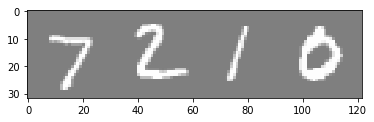

In [7]:
#정답값과 이미지 출력
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print(''.join('%5d' % labels[j] for j in range(4)))
plt.show()

In [8]:
outputs = net(images)

In [9]:
#output은 10개의 class를 각각 예측해서 값을 갖고 있는데 그 중 max값을 저장
_, predicted = torch.max(outputs, 1)

print(''.join('%5d' % predicted[j] for j in range(4)))

    7    2    1    0


In [10]:
#전체 dataset을 통해 정확도를 check
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 96 %


In [11]:
'''
import random

r = random.randint(0, len(testset) -1)
X_single_data = Variable(testset.test_data[r:r + 1].view(-1,28 * 28).float())
Y_single_data = Variable(testset.test_labels[r:r + 1])

single_prediction = Net(X_single_data)

print("Label : ", Y_single_data.data)
print("Prediction : ", torch.max(single_prediction.data, 1)[1])

plt.imshow(X_single_data.data.view(28,28).numpy(), cmap='gray')
plt.show()
'''

'\nimport random\n\nr = random.randint(0, len(testset) -1)\nX_single_data = Variable(testset.test_data[r:r + 1].view(-1,28 * 28).float())\nY_single_data = Variable(testset.test_labels[r:r + 1])\n\nsingle_prediction = Net(X_single_data)\n\nprint("Label : ", Y_single_data.data)\nprint("Prediction : ", torch.max(single_prediction.data, 1)[1])\n\nplt.imshow(X_single_data.data.view(28,28).numpy(), cmap=\'gray\')\nplt.show()\n'

In [12]:
'''
튜토리얼 과정
1. training, test 데이터셋을 불러오고 정규화
2. CNN모델 정의
3. loss와 optimizer 정의(손실함수와 경사하강법)
4. training data로 신경망 학습
5. test data로 검사(정확도 검사)
'''

'\n튜토리얼 과정\n1. training, test 데이터셋을 불러오고 정규화\n2. CNN모델 정의\n3. loss와 optimizer 정의(손실함수와 경사하강법)\n4. training data로 신경망 학습\n5. test data로 검사(정확도 검사)\n'